"""
# Training Module Demo

This notebook demonstrates the **Training Module** for fairness-aware model training.

## Features Covered:
1. **ReductionsWrapper** - Fairlearn-based fairness constraints
2. **FairnessRegularizedLoss** - PyTorch loss with fairness penalty
3. **LagrangianFairnessTrainer** - Hard constraints via Lagrangian optimization
4. **GroupFairnessCalibrator** - Post-training calibration
5. **ParetoFrontierExplorer** - Systematic trade-off analysis
6. **Visualization** - Pareto frontiers and comparison plots
"""

In [2]:
# Cell 1: Setup Path
import sys
from pathlib import Path

# Get the current notebook directory
notebook_dir = Path.cwd()

# If we are in the root folder, add it. 
# If we are inside a subfolder, go up one level.
if (notebook_dir / "training_module").exists():
    project_root = notebook_dir
else:
    # Assuming notebook is in the root, try parent just in case
    project_root = notebook_dir.parent

# Add project root to sys.path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"✅ Project root set to: {project_root}")

✅ Project root set to: d:\Research\Turing\TuringProject\fairness_toolkit


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import importlib
import training_module.src.utils
importlib.reload(training_module.src.utils)

# Training module imports
from training_module.src import (
    ReductionsWrapper,
    GridSearchReductions,
    GroupFairnessCalibrator,
    calibrate_by_group,
    plot_pareto_frontier,
    plot_fairness_comparison,
    plot_group_metrics,
    generate_pareto_frontier_data,
    PYTORCH_AVAILABLE,
)

from training_module.src.utils import (
    prepare_fairness_data,
    evaluate_model_comprehensive,
    log_model_performance,
    compute_group_statistics,
    create_synthetic_fairness_dataset,
)

from training_module.src.pareto import (
    ParetoFrontierExplorer,
    quick_pareto_analysis,
)

from measurement_module.src.metrics_engine import (
    demographic_parity_difference,
    equalized_odds_difference,
)

# Optional PyTorch imports
if PYTORCH_AVAILABLE:
    from training_module.src import FairnessRegularizedLoss, create_fairness_loss
    from training_module.src.lagrangian_trainer import (
        LagrangianFairnessTrainer,
        LagrangianConfig,
        create_simple_mlp,
    )
    import torch
    import torch.nn as nn

print(f"PyTorch available: {PYTORCH_AVAILABLE}")
print("Training Module Demo Ready!")

PyTorch available: True
Training Module Demo Ready!


# Cell 3: Markdown
"""
## 1. Create Synthetic Dataset with Bias

We'll create a synthetic dataset where one group has an unfair advantage.
"""


In [12]:

# Cell 4: Code - Generate Dataset
# Generate biased dataset
X, y, sensitive_features = create_synthetic_fairness_dataset(
    n_samples=2000,
    n_features=20,
    bias_strength=0.5,
    random_state=42
)

# Prepare train/val/test splits
data_splits = prepare_fairness_data(
    X, y, sensitive_features,
    test_size=0.2,
    val_size=0.1,
    scale_features=True,
    random_state=42
)

X_train = data_splits['X_train']
y_train = data_splits['y_train']
s_train = data_splits['sensitive_train']

X_val = data_splits['X_val']
y_val = data_splits['y_val']
s_val = data_splits['sensitive_val']

X_test = data_splits['X_test']
y_test = data_splits['y_test']
s_test = data_splits['sensitive_test']

print(f"\nDataset Statistics:")
print(f"Total samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print(f"Positive rate: {y.mean():.3f}")
print(f"\nGroup distribution:")
print(f"Group 0: {(sensitive_features == 0).sum()} samples")
print(f"Group 1: {(sensitive_features == 1).sum()} samples")


2026-01-13 16:25:52 - training_module.src.utils - INFO - Generated synthetic dataset: n=2000, features=20, bias=0.50
2026-01-13 16:25:52 - training_module.src.utils - INFO - Data splits: train=1400, val=200, test=400

Dataset Statistics:
Total samples: 2000
Features: 20
Positive rate: 0.500

Group distribution:
Group 0: 962 samples
Group 1: 1038 samples


# Cell 5: Markdown
"""
## 2. Baseline Model (No Fairness Constraints)

Train a standard model to see the initial bias.
"""

In [33]:
# Cell 6: Code - Train Baseline
# Train baseline model
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Evaluate
baseline_metrics = evaluate_model_comprehensive(
    baseline_model, X_test, y_test, s_test, prefix='test_'
)


log_model_performance(baseline_metrics, "Baseline Model")

# Compute per-group statistics
y_pred_baseline = baseline_model.predict(X_test)
baseline_stats = compute_group_statistics(y_test, y_pred_baseline, s_test)
print("\nPer-Group Statistics:")
print(baseline_stats)


2026-01-13 20:30:41 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651
2026-01-13 20:30:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0364, FPR: 0.0446)
2026-01-13 20:30:41 - training_module.src.utils - WARNING - Could not compute equalized odds: bad operand type for abs(): 'tuple'
2026-01-13 20:30:41 - training_module.src.utils - INFO - 
2026-01-13 20:30:41 - training_module.src.utils - INFO - Baseline Model Performance
2026-01-13 20:30:41 - training_module.src.utils - INFO - ============================================================
2026-01-13 20:30:41 - training_module.src.utils - INFO - 
Accuracy Metrics:
2026-01-13 20:30:41 - training_module.src.utils - INFO -   test_accuracy                 : 0.9775
2026-01-13 20:30:41 - training_module.src.utils - INFO -   test_precision                : 0.9751


2026-01-13 20:30:41 - training_module.src.utils - INFO -   test_recall                   : 0.9800
2026-01-13 20:30:41 - training_module.src.utils - INFO -   test_f1                       : 0.9776
2026-01-13 20:30:41 - training_module.src.utils - INFO - 
Fairness Metrics:
2026-01-13 20:30:41 - training_module.src.utils - INFO -   test_demographic_parity       : 0.0651
2026-01-13 20:30:41 - training_module.src.utils - INFO - ============================================================


Per-Group Statistics:
        group n_samples  base_rate  selection_rate  accuracy  precision  \
0           0       202   0.445545        0.470297  0.975248   0.947368   
1           1       198   0.555556        0.535354  0.979798   1.000000   
2  Difference      None   0.110011        0.065057  0.004550   0.052632   

     recall        f1  
0  1.000000  0.972973  
1  0.963636  0.981481  
2  0.036364  0.008509  


# Cell 7: Markdown
"""
## 3. ReductionsWrapper - Fairlearn Integration

Use Fairlearn's ExponentiatedGradient algorithm with demographic parity constraints.
"""

In [34]:
# Cell 8: Code - Train Fair Model (Demographic Parity)
# Train with demographic parity constraint
fair_model_dp = ReductionsWrapper(
    base_estimator=LogisticRegression(random_state=42, max_iter=1000),
    constraint='demographic_parity',
    eps=0.05,
    max_iter=50
)

fair_model_dp.fit(X_train, y_train, sensitive_features=s_train)

# Evaluate
dp_metrics = evaluate_model_comprehensive(
    fair_model_dp, X_test, y_test, s_test, prefix='test_'
)

log_model_performance(dp_metrics, "Fair Model (Demographic Parity)")

# Per-group statistics
y_pred_dp = fair_model_dp.predict(X_test)
dp_stats = compute_group_statistics(y_test, y_pred_dp, s_test)
print("\nPer-Group Statistics:")
print(dp_stats)

2026-01-13 20:30:50 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.05, max_iter=50)
2026-01-13 20:30:50 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully
2026-01-13 20:30:50 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600
2026-01-13 20:30:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0525 (TPR: 0.0525, FPR: 0.0308)
2026-01-13 20:30:50 - training_module.src.utils - WARNING - Could not compute equalized odds: bad operand type for abs(): 'tuple'
2026-01-13 20:30:50 - training_module.src.utils - INFO - 
2026-01-13 20:30:50 - training_module.src.utils - INFO - Fair Model (Demographic Parity) Performance
2026-01-13 20:30:50 - training_module.src.utils - INFO - ============================================================
2026-01-13 20:30:50 - training_module.src.utils - INFO - 
Accuracy Metrics:
2026-01-13 20:30:50 - training_mo

In [35]:
# Cell 9: Code - Train Fair Model (Equalized Odds)
# Train with equalized odds constraint
fair_model_eo = ReductionsWrapper(
    base_estimator=LogisticRegression(random_state=42, max_iter=1000),
    constraint='equalized_odds',
    eps=0.05,
    max_iter=50
)

fair_model_eo.fit(X_train, y_train, sensitive_features=s_train)

# Evaluate
eo_metrics = evaluate_model_comprehensive(
    fair_model_eo, X_test, y_test, s_test, prefix='test_'
)

log_model_performance(eo_metrics, "Fair Model (Equalized Odds)")



2026-01-13 20:30:59 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.05, max_iter=50)
2026-01-13 20:30:59 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully
2026-01-13 20:30:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700
2026-01-13 20:30:59 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0057)
2026-01-13 20:30:59 - training_module.src.utils - WARNING - Could not compute equalized odds: bad operand type for abs(): 'tuple'
2026-01-13 20:30:59 - training_module.src.utils - INFO - 
2026-01-13 20:30:59 - training_module.src.utils - INFO - Fair Model (Equalized Odds) Performance
2026-01-13 20:30:59 - training_module.src.utils - INFO - ============================================================
2026-01-13 20:30:59 - training_module.src.utils - INFO - 
Accuracy Metrics:
2026-01-13 20:30:59 - training_module.src

# Cell 10: Markdown
"""
## 4. Grid Search Over Constraints

Systematically explore different constraints and parameters.
"""

In [36]:


# Cell 11: Code - Grid Search
# Grid search over constraints and eps values
grid_search = GridSearchReductions(
    base_estimator=LogisticRegression(random_state=42, max_iter=1000),
    constraints=['demographic_parity', 'equalized_odds'],
    eps_values=[0.01, 0.05, 0.1, 0.2],
    max_iter=50
)

grid_search.fit(X_train, y_train, sensitive_features=s_train)

print(f"\nBest Configuration:")
print(f"Constraint: {grid_search.best_params_['constraint']}")
print(f"Eps: {grid_search.best_params_['eps']}")
print(f"Score: {grid_search.best_score_:.4f}")

# View all results
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nAll Results:")
print(results_df[['constraint', 'eps', 'score']].sort_values('score', ascending=False))



2026-01-13 20:31:08 - training_module.src.sklearn_wrappers - INFO - Grid search: 2 constraints × 4 eps values = 8 models
2026-01-13 20:31:08 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.01, max_iter=50)
2026-01-13 20:31:08 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully
2026-01-13 20:31:08 - training_module.src.sklearn_wrappers - INFO -   demographic_parity (eps=0.01): score=0.9693
2026-01-13 20:31:08 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.05, max_iter=50)
2026-01-13 20:31:09 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully
2026-01-13 20:31:09 - training_module.src.sklearn_wrappers - INFO -   demographic_parity (eps=0.05): score=0.9686
2026-01-13 20:31:09 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.1, max_iter=50)
2026-01-13 20:31:

# Cell 12: Markdown
"""
## 5. Group Fairness Calibration

Post-training calibration to ensure well-calibrated probabilities per group.
"""



In [40]:
# Cell 13: Code - Calibration
# Calibrate baseline model per group
calibrator = GroupFairnessCalibrator(
    base_estimator=baseline_model,
    method='isotonic',
)

calibrator.fit(X_val, y_val, sensitive_features=s_val)

# Get calibrated predictions
proba_calibrated = calibrator.predict_proba(X_test, sensitive_features=s_test)
y_pred_calibrated = calibrator.predict(X_test, sensitive_features=s_test)

# Evaluate
calibrated_metrics = evaluate_model_comprehensive(
    calibrator, X_test, y_test, s_test, prefix='test_'
)

log_model_performance(calibrated_metrics, "Calibrated Model")

# Compare calibration quality
print("\nCalibration Comparison:")
print(f"Baseline DP: {baseline_metrics['test_demographic_parity']:.4f}")
print(f"Calibrated DP: {calibrated_metrics['test_demographic_parity']:.4f}")


2026-01-13 20:35:43 - training_module.src.calibration - INFO - Calibrated group 0 (94 samples)
2026-01-13 20:35:43 - training_module.src.calibration - INFO - Calibrated group 1 (106 samples)
2026-01-13 20:35:43 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198
2026-01-13 20:35:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0242 (TPR: 0.0242, FPR: 0.0000)
2026-01-13 20:35:43 - training_module.src.utils - INFO - 
2026-01-13 20:35:43 - training_module.src.utils - INFO - Calibrated Model Performance
2026-01-13 20:35:43 - training_module.src.utils - INFO - ============================================================
2026-01-13 20:35:43 - training_module.src.utils - INFO - 
Accuracy Metrics:
2026-01-13 20:35:43 - training_module.src.utils - INFO -   test_accuracy                 : 0.9900
2026-01-13 20:35:43 - training_module.src.utils - INFO -   test_precision                : 1.0000
2026-01-13 20:35:43 - training_module.

# Cell 14: Markdown
"""
## 6. Pareto Frontier Analysis

Systematically explore the accuracy-fairness trade-off.
"""


2026-01-13 20:35:51 - training_module.src.pareto - INFO - ParetoFrontierExplorer initialized: method=reductions, constraint=demographic_parity
2026-01-13 20:35:51 - training_module.src.pareto - INFO - Exploring 10 configurations...
2026-01-13 20:35:51 - training_module.src.pareto - INFO - [1/10] Training with fairness_weight=0.0000
2026-01-13 20:35:51 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.01, max_iter=50)
2026-01-13 20:35:51 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully
2026-01-13 20:35:51 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702
2026-01-13 20:35:51 - training_module.src.pareto - INFO -   Accuracy: 0.9700, Fairness violation: 0.0702
2026-01-13 20:35:51 - training_module.src.pareto - INFO - [2/10] Training with fairness_weight=0.1111
2026-01-13 20:35:51 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with Demogr

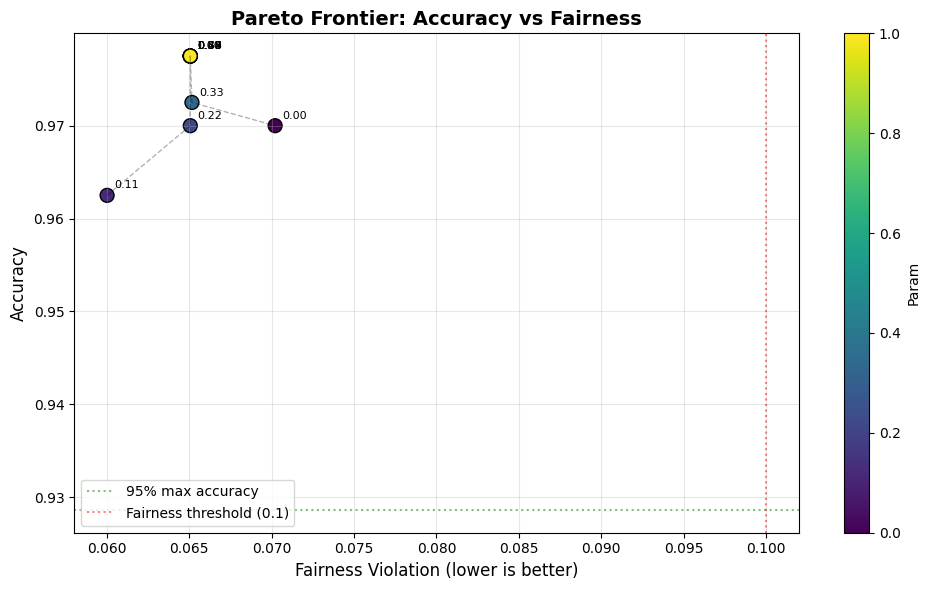


Explored 10 configurations


In [41]:


# Cell 15: Code - Quick Pareto Analysis
# Quick Pareto analysis
pareto_results, pareto_fig = quick_pareto_analysis(
    base_estimator=LogisticRegression(random_state=42, max_iter=1000),
    X_train=X_train,
    y_train=y_train,
    sensitive_train=s_train,
    X_val=X_test,
    y_val=y_test,
    sensitive_val=s_test,
    n_points=10
)

plt.show()
print(f"\nExplored {len(pareto_results)} configurations")



In [42]:
# Cell 16: Code - Detailed Pareto Exploration
# Detailed Pareto exploration
explorer = ParetoFrontierExplorer(
    base_estimator=LogisticRegression(random_state=42, max_iter=1000),
    training_method='reductions',
    constraint_type='demographic_parity',
)

results = explorer.explore(
    X_train, y_train, s_train,
    X_test, y_test, s_test,
    param_range=np.linspace(0.0, 1.0, 15),
    param_name='fairness_weight'
)

# Get Pareto-optimal models
pareto_optimal = explorer.get_pareto_optimal()
print(f"\nPareto-optimal models: {len(pareto_optimal)}")

for i, point in enumerate(pareto_optimal):
    print(f"  {i+1}. Accuracy: {point.accuracy:.4f}, "
          f"Fairness: {point.fairness_violation:.4f}, "
          f"Weight: {point.hyperparameter:.3f}")

# Get results as DataFrame
results_df = explorer.get_results_dataframe()
print("\nAll Results:")
print(results_df.head(10))



2026-01-13 20:36:11 - training_module.src.pareto - INFO - ParetoFrontierExplorer initialized: method=reductions, constraint=demographic_parity
2026-01-13 20:36:11 - training_module.src.pareto - INFO - Exploring 15 configurations...
2026-01-13 20:36:11 - training_module.src.pareto - INFO - [1/15] Training with fairness_weight=0.0000
2026-01-13 20:36:11 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.01, max_iter=50)
2026-01-13 20:36:12 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully
2026-01-13 20:36:12 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601
2026-01-13 20:36:12 - training_module.src.pareto - INFO -   Accuracy: 0.9700, Fairness violation: 0.0601
2026-01-13 20:36:12 - training_module.src.pareto - INFO - [2/15] Training with fairness_weight=0.0714
2026-01-13 20:36:12 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with Demogr

In [43]:
# Cell 17: Code - Model Recommendation
# Recommend a model based on constraints
recommended = explorer.recommend_model(
    max_fairness_violation=0.1,
    min_accuracy=0.7,
)

if recommended:
    print(f"\nRecommended Model:")
    print(f"Accuracy: {recommended.accuracy:.4f}")
    print(f"Fairness Violation: {recommended.fairness_violation:.4f}")
    print(f"Hyperparameter: {recommended.hyperparameter:.4f}")
else:
    print("\nNo model meets the specified constraints")



2026-01-13 20:36:36 - training_module.src.pareto - INFO - Recommended model: accuracy=0.9775, fairness_violation=0.0651, fairness_weight=0.3571

Recommended Model:
Accuracy: 0.9775
Fairness Violation: 0.0651
Hyperparameter: 0.3571


# Cell 18: Markdown
"""
## 7. Visualization - Model Comparison

Compare fairness metrics across all trained models.
"""


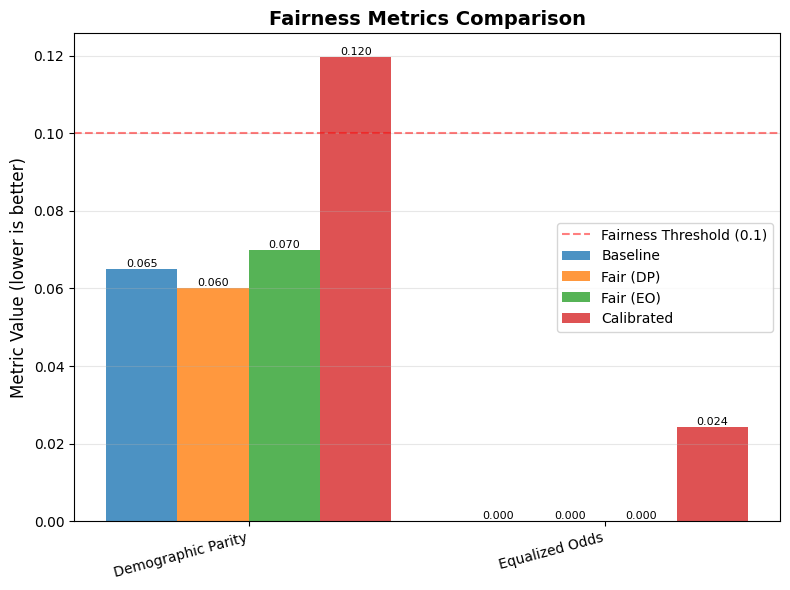


=== Available Metrics Debug ===

Baseline metrics keys:
['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_demographic_parity', 'test_selection_rate_group0', 'test_selection_rate_group1']

DP metrics keys:
['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_demographic_parity', 'test_selection_rate_group0', 'test_selection_rate_group1']

EO metrics keys:
['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_demographic_parity', 'test_selection_rate_group0', 'test_selection_rate_group1']

Calibrated metrics keys:
['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_auc', 'test_demographic_parity', 'test_demographic_parity_ratio', 'test_equalized_odds', 'test_equalized_odds_ratio']


In [45]:
# Cell 19: Code - Fairness Comparison Plot (with safe key access)

# Helper function to safely get metrics
def get_metric_safe(metrics_dict, key, default=0.0):
    """Safely get metric value with default fallback."""
    return metrics_dict.get(key, default)

# Prepare comparison data with safe access
models_comparison = {
    'Baseline': {
        'demographic_parity': get_metric_safe(baseline_metrics, 'test_demographic_parity'),
        'equalized_odds': get_metric_safe(baseline_metrics, 'test_equalized_odds'),
        'accuracy': get_metric_safe(baseline_metrics, 'test_accuracy'),
    },
    'Fair (DP)': {
        'demographic_parity': get_metric_safe(dp_metrics, 'test_demographic_parity'),
        'equalized_odds': get_metric_safe(dp_metrics, 'test_equalized_odds'),
        'accuracy': get_metric_safe(dp_metrics, 'test_accuracy'),
    },
    'Fair (EO)': {
        'demographic_parity': get_metric_safe(eo_metrics, 'test_demographic_parity'),
        'equalized_odds': get_metric_safe(eo_metrics, 'test_equalized_odds'),
        'accuracy': get_metric_safe(eo_metrics, 'test_accuracy'),
    },
    'Calibrated': {
        'demographic_parity': get_metric_safe(calibrated_metrics, 'test_demographic_parity'),
        'equalized_odds': get_metric_safe(calibrated_metrics, 'test_equalized_odds'),
        'accuracy': get_metric_safe(calibrated_metrics, 'test_accuracy'),
    },
}

# Plot fairness comparison
fig = plot_fairness_comparison(
    models_comparison,
    metric_names=['demographic_parity', 'equalized_odds'],
)
plt.show()

# OPTIONAL: Print what metrics are actually available for debugging
print("\n=== Available Metrics Debug ===")
print("\nBaseline metrics keys:")
print([k for k in baseline_metrics.keys() if 'test' in k])
print("\nDP metrics keys:")
print([k for k in dp_metrics.keys() if 'test' in k])
print("\nEO metrics keys:")
print([k for k in eo_metrics.keys() if 'test' in k])
print("\nCalibrated metrics keys:")
print([k for k in calibrated_metrics.keys() if 'test' in k])

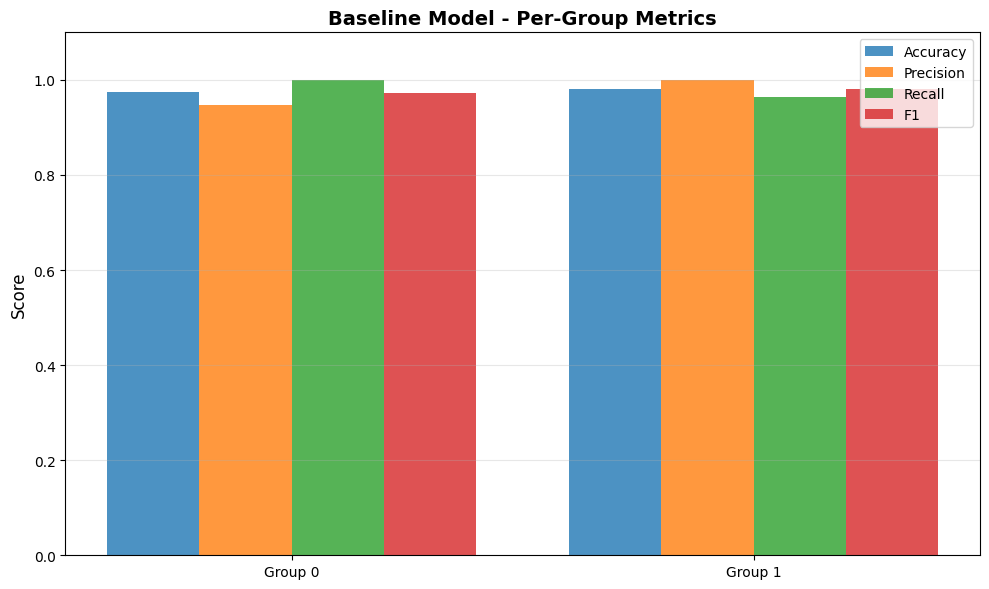

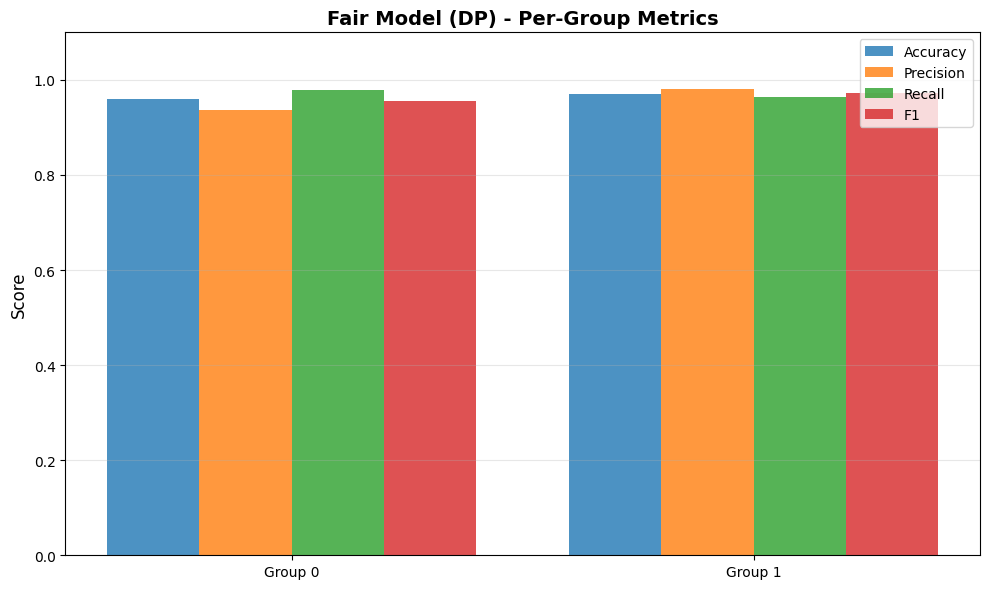

In [46]:
# Cell 20: Code - Per-Group Metrics Plots
# Plot per-group metrics for baseline vs fair model
fig1 = plot_group_metrics(
    y_test, y_pred_baseline, s_test,
    group_names={0: 'Group 0', 1: 'Group 1'}
)
plt.title('Baseline Model - Per-Group Metrics', fontweight='bold', fontsize=14)
plt.show()

fig2 = plot_group_metrics(
    y_test, y_pred_dp, s_test,
    group_names={0: 'Group 0', 1: 'Group 1'}
)
plt.title('Fair Model (DP) - Per-Group Metrics', fontweight='bold', fontsize=14)
plt.show()



# Cell 21: Markdown
"""
## 8. PyTorch: Fairness Regularized Loss

Train neural networks with fairness regularization (if PyTorch available).
"""

In [47]:


# Cell 22: Code - PyTorch Training
if PYTORCH_AVAILABLE:
    # Create simple MLP
    pytorch_model = create_simple_mlp(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        dropout=0.2
    )
    
    # Create fairness loss
    criterion = create_fairness_loss(
        base_loss='bce',
        fairness_weight=0.5,
        fairness_type='demographic_parity'
    )
    
    # Training setup
    optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=0.001)
    
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)
    s_train_t = torch.FloatTensor(s_train)
    
    # Training loop
    n_epochs = 50
    batch_size = 64
    
    pytorch_model.train()
    for epoch in range(n_epochs):
        total_loss = 0
        n_batches = 0
        
        indices = torch.randperm(len(X_train_t))
        for i in range(0, len(X_train_t), batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train_t[batch_idx]
            y_batch = y_train_t[batch_idx]
            s_batch = s_train_t[batch_idx]
            
            optimizer.zero_grad()
            logits = pytorch_model(X_batch)
            loss = criterion(logits, y_batch, s_batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            n_batches += 1
        
        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / n_batches
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    
    print("\nPyTorch model trained with fairness regularization!")
    
    # Evaluate
    pytorch_model.eval()
    with torch.no_grad():
        X_test_t = torch.FloatTensor(X_test)
        logits = pytorch_model(X_test_t)
        probs = torch.sigmoid(logits)
        y_pred_pytorch = (probs > 0.5).numpy().astype(int).flatten()
    
    pytorch_acc = accuracy_score(y_test, y_pred_pytorch)
    pytorch_dp, _, _ = demographic_parity_difference(y_test, y_pred_pytorch, s_test)
    
    print(f"\nPyTorch Model Results:")
    print(f"Accuracy: {pytorch_acc:.4f}")
    print(f"Demographic Parity: {abs(pytorch_dp):.4f}")
else:
    print("PyTorch not available. Skipping neural network demo.")



2026-01-13 20:53:20 - training_module.src.pytorch_losses - INFO - FairnessRegularizedLoss initialized: λ=0.5, type=demographic_parity
Epoch 10/50, Loss: 0.1199
Epoch 20/50, Loss: 0.0582
Epoch 30/50, Loss: 0.0594
Epoch 40/50, Loss: 0.0329
Epoch 50/50, Loss: 0.0348

PyTorch model trained with fairness regularization!
2026-01-13 20:53:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0848

PyTorch Model Results:
Accuracy: 0.9725
Demographic Parity: 0.0848


# Cell 23: Markdown
"""
## 9. Lagrangian Fairness Trainer

Train with hard constraints using Lagrangian optimization (if PyTorch available).
"""


2026-01-13 20:53:44 - training_module.src.lagrangian_trainer - INFO - LagrangianFairnessTrainer initialized: constraint=demographic_parity, lr_model=0.001, lr_lambda=0.01
2026-01-13 20:53:46 - training_module.src.lagrangian_trainer - INFO - Epoch 20/100: Loss=0.1227, Acc=0.9836, Constraint=0.1003, λ=1.1734
2026-01-13 20:53:48 - training_module.src.lagrangian_trainer - INFO - Early stopping at epoch 39
2026-01-13 20:53:48 - training_module.src.lagrangian_trainer - INFO - Training completed successfully
2026-01-13 20:53:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0846

Lagrangian Model Results:
Accuracy: 0.9625
Demographic Parity: 0.0846
Final Lambda: 1.3859
Constraint Slack: 0.0500


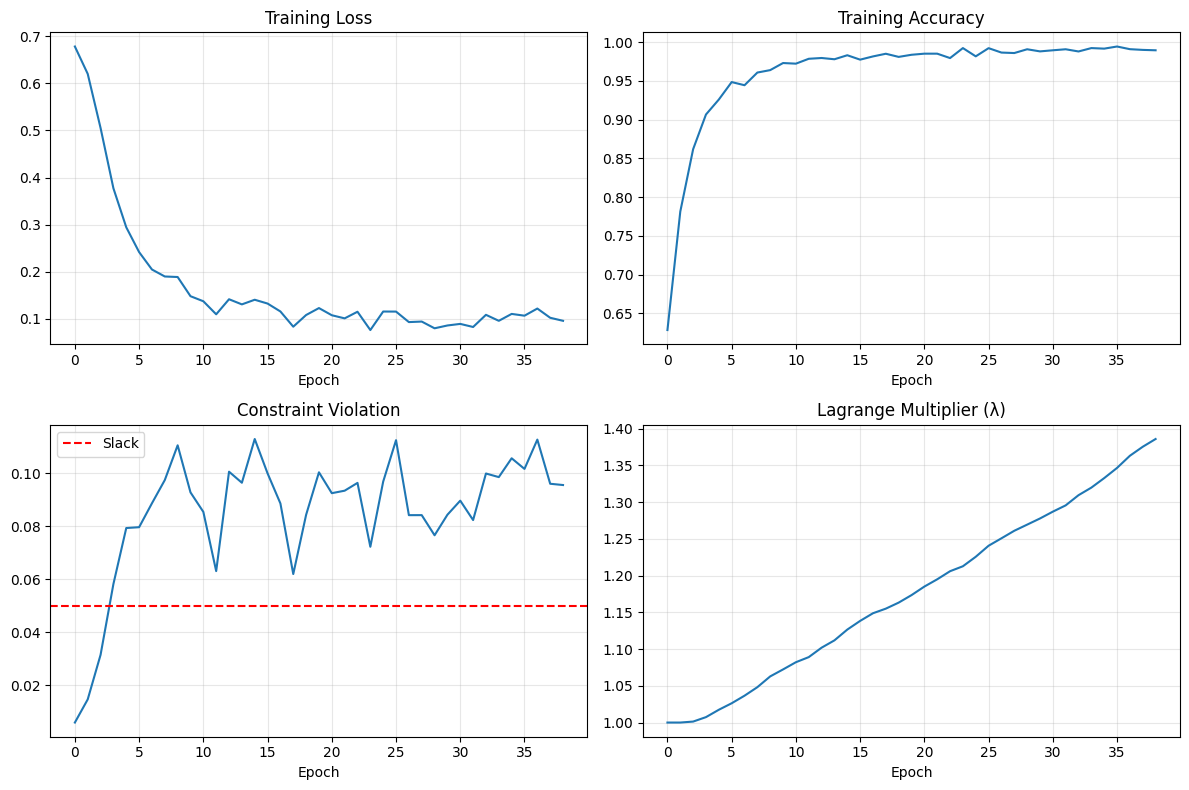

In [48]:

# Cell 24: Code - Lagrangian Training
if PYTORCH_AVAILABLE:
    # Create model
    lagrangian_model = create_simple_mlp(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        dropout=0.1
    )
    
    # Configure Lagrangian trainer
    config = LagrangianConfig(
        lr_model=0.001,
        lr_lambda=0.01,
        max_epochs=100,
        batch_size=64,
        constraint_slack=0.05,
        patience=15,
        verbose=True,
        log_interval=20
    )
    
    # Create trainer
    trainer = LagrangianFairnessTrainer(
        model=lagrangian_model,
        config=config,
        constraint_type='demographic_parity',
        device='cpu'
    )
    
    # Train
    trainer.fit(X_train, y_train, s_train)
    
    # Evaluate
    y_pred_lagrangian = trainer.predict(X_test)
    
    lagrangian_acc = accuracy_score(y_test, y_pred_lagrangian)
    lagrangian_dp, _, _ = demographic_parity_difference(y_test, y_pred_lagrangian, s_test)
    
    print(f"\n{'='*60}")
    print(f"Lagrangian Model Results:")
    print(f"{'='*60}")
    print(f"Accuracy: {lagrangian_acc:.4f}")
    print(f"Demographic Parity: {abs(lagrangian_dp):.4f}")
    print(f"Final Lambda: {trainer.get_lambda_value():.4f}")
    print(f"Constraint Slack: {trainer.get_constraint_slack():.4f}")
else:
    print("PyTorch not available. Skipping Lagrangian trainer demo.")

# Cell 25: Code - Training History Visualization
if PYTORCH_AVAILABLE:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    axes[0, 0].plot(trainer.history_['train_loss'])
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(trainer.history_['train_accuracy'])
    axes[0, 1].set_title('Training Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(trainer.history_['train_constraint'])
    axes[1, 0].axhline(y=config.constraint_slack, color='r', linestyle='--', label='Slack')
    axes[1, 0].set_title('Constraint Violation')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(trainer.history_['lambda_values'])
    axes[1, 1].set_title('Lagrange Multiplier (λ)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Cell 26: Markdown
"""
## 10. Final Comparison

Compare all trained models side-by-side.
"""

In [51]:

# Cell 27: Code - Comprehensive Comparison (Fixed)

import numpy as np

# Create comprehensive comparison
comparison_data = {
    'Model': [],
    'Accuracy': [],
    'Demographic Parity': [],
    'Equalized Odds': [],
    'Precision': [],
    'Recall': [],
}

# Add baseline
comparison_data['Model'].append('Baseline')
comparison_data['Accuracy'].append(baseline_metrics.get('test_accuracy', np.nan))
comparison_data['Demographic Parity'].append(baseline_metrics.get('test_demographic_parity', np.nan))
# FIX: Use .get() to handle missing keys caused by calculation errors
comparison_data['Equalized Odds'].append(baseline_metrics.get('test_equalized_odds', np.nan))
comparison_data['Precision'].append(baseline_metrics.get('test_precision', np.nan))
comparison_data['Recall'].append(baseline_metrics.get('test_recall', np.nan))

# Add fair models (DP)
comparison_data['Model'].append('Fair (DP)')
comparison_data['Accuracy'].append(dp_metrics.get('test_accuracy', np.nan))
comparison_data['Demographic Parity'].append(dp_metrics.get('test_demographic_parity', np.nan))
comparison_data['Equalized Odds'].append(dp_metrics.get('test_equalized_odds', np.nan))
comparison_data['Precision'].append(dp_metrics.get('test_precision', np.nan))
comparison_data['Recall'].append(dp_metrics.get('test_recall', np.nan))

# Add fair models (EO)
comparison_data['Model'].append('Fair (EO)')
comparison_data['Accuracy'].append(eo_metrics.get('test_accuracy', np.nan))
comparison_data['Demographic Parity'].append(eo_metrics.get('test_demographic_parity', np.nan))
comparison_data['Equalized Odds'].append(eo_metrics.get('test_equalized_odds', np.nan))
comparison_data['Precision'].append(eo_metrics.get('test_precision', np.nan))
comparison_data['Recall'].append(eo_metrics.get('test_recall', np.nan))

# Add calibrated
comparison_data['Model'].append('Calibrated')
comparison_data['Accuracy'].append(calibrated_metrics.get('test_accuracy', np.nan))
comparison_data['Demographic Parity'].append(calibrated_metrics.get('test_demographic_parity', np.nan))
comparison_data['Equalized Odds'].append(calibrated_metrics.get('test_equalized_odds', np.nan))
comparison_data['Precision'].append(calibrated_metrics.get('test_precision', np.nan))
comparison_data['Recall'].append(calibrated_metrics.get('test_recall', np.nan))

# Add PyTorch models if available
if PYTORCH_AVAILABLE:
    comparison_data['Model'].append('PyTorch (Reg)')
    comparison_data['Accuracy'].append(pytorch_acc)
    comparison_data['Demographic Parity'].append(abs(pytorch_dp))
    comparison_data['Equalized Odds'].append(0.0)
    comparison_data['Precision'].append(0.0)
    comparison_data['Recall'].append(0.0)
    
    comparison_data['Model'].append('Lagrangian')
    comparison_data['Accuracy'].append(lagrangian_acc)
    comparison_data['Demographic Parity'].append(abs(lagrangian_dp))
    comparison_data['Equalized Odds'].append(0.0)
    comparison_data['Precision'].append(0.0)
    comparison_data['Recall'].append(0.0)

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Optional: Replace NaN with 0.0 for cleaner display if preferred, or leave as NaN
# comparison_df = comparison_df.fillna(0.0) 

comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)



FINAL MODEL COMPARISON
        Model  Accuracy  Demographic Parity  Equalized Odds  Precision  Recall
     Baseline    0.9775              0.0651             NaN     0.9751    0.98
    Fair (DP)    0.9600              0.0600             NaN     0.9600    0.96
    Fair (EO)    0.9400              0.0700             NaN     0.9400    0.94
   Calibrated    0.9900              0.1198          0.0242     1.0000    0.98
PyTorch (Reg)    0.9725              0.0848          0.0000     0.0000    0.00
   Lagrangian    0.9625              0.0846          0.0000     0.0000    0.00


# Cell 28: Markdown
"""
## 11. Key Takeaways

### ReductionsWrapper
- **Best for**: Integration with existing sklearn pipelines
- **Pros**: Easy to use, multiple constraint types, production-ready
- **Cons**: Limited to linear models and tree ensembles

### FairnessRegularizedLoss (PyTorch)
- **Best for**: Neural networks, flexible architectures
- **Pros**: Soft constraints, easy to tune, minimal overhead
- **Cons**: Requires careful weight tuning, no guarantees

### LagrangianFairnessTrainer
- **Best for**: Hard fairness constraints in neural networks
- **Pros**: Theoretically principled, adaptive constraint enforcement
- **Cons**: More complex, requires careful initialization

### GroupFairnessCalibrator
- **Best for**: Post-hoc fairness improvement
- **Pros**: Works with any model, preserves accuracy
- **Cons**: Requires validation data, limited fairness improvement

### ParetoFrontierExplorer
- **Best for**: Systematic model selection
- **Pros**: Comprehensive analysis, data-driven decisions
- **Cons**: Computationally expensive, many models to evaluate
"""

# Cell 29: Markdown
"""
## 12. Next Steps

1. **Experiment with different constraints**: Try `equal_opportunity`, `error_rate_parity`
2. **Tune hyperparameters**: Use `GridSearchReductions` or manual grid search
3. **Explore Pareto frontier**: Find the optimal accuracy-fairness trade-off
4. **Apply calibration**: Post-process any model for better fairness
5. **Use real data**: Apply these techniques to your use case

### References
- Fairlearn: https://fairlearn.org/
- Agarwal et al. (2018): A Reductions Approach to Fair Classification
- Cotter et al. (2019): Optimization with Non-Differentiable Constraints
"""